In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('tufte')

# Getting 1,000 samples of a linear regression model in different Probabilistic Programming Languages

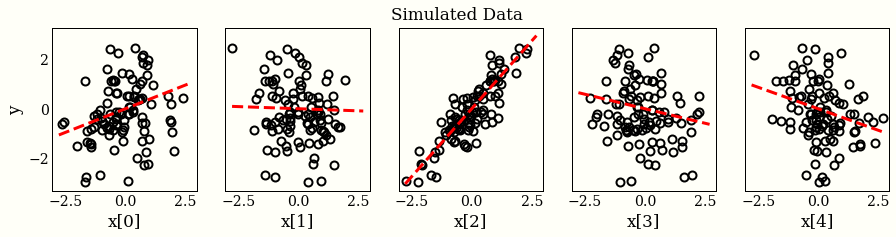

In [3]:
# Trailing underscore means the model has no access to the variable
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



## PyMC3

https://docs.pymc.io/

In [4]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    trace = pm.sample(1000)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3089.75draws/s]


In [5]:
pm.__version__

'3.7'

## PyStan

https://pystan.readthedocs.io

In [6]:
import pystan

linear_regression = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] w;       // coefficients for predictors
}
model {
  y ~ normal(X * w, 0.1);  // likelihood
}
"""

linear_data = {'N': ndata,
               'K': ndims,
               'y': y_obs,
               'X': X
              }

sm = pystan.StanModel(model_code=linear_regression)
fit = sm.sampling(data=linear_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b8e41c9d58148edcdc9d099a42ee4b NOW.


In [7]:
pystan.__version__

'2.19.0.0'

## emcee

https://emcee.readthedocs.io

In [8]:
import scipy.stats as st

import emcee

# log likelihood
def lnlike(w, X, y):
    model = X.dot(w) 
    inv_sigma2 = 0.1 ** -2
    return -0.5*(np.sum((y-model)**2)*inv_sigma2 - np.log(inv_sigma2))

# Define a prior for w
w_rv = st.multivariate_normal(np.zeros(ndims), np.eye(ndims))

# Log probability for w
lnprior = w_rv.logpdf

# logp(w | X, y) = logp(y | X, w) + logp(w)
def lnprob(w, X, y):
    return lnprior(w) + lnlike(w, X, y)

nwalkers = 100
pos = w_rv.rvs(size=nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, args=(X, y_obs))

pos, lprob, rstate  = sampler.run_mcmc(pos, 1000)

In [9]:
emcee.__version__

'2.2.1'

## Tensorflow Probability

https://www.tensorflow.org/probability

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=0.1, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return w_prob + y_prob


# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

W0723 15:53:36.508431 140198056003328 deprecation.py:323] From /home/colin/miniconda3/envs/scratch3.6/lib/python3.6/site-packages/tensorflow_core/python/ops/math_ops.py:2451: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
tfp.__version__

'0.8.0-dev20190721'

## Pyro

https://pyro.ai/

In [12]:
import pyro
import torch
from pyro.infer.mcmc import NUTS, MCMC
import pyro.distributions as dist


def model(X):
    w = pyro.sample('w', dist.Normal(torch.zeros(ndims), torch.ones(ndims)))
    y = pyro.sample('y', dist.Normal(torch.matmul(X, w), 0.1 * torch.ones(ndata)), obs=torch.as_tensor(y_obs, dtype=torch.float32))
    return y

nuts_kernel = NUTS(model, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=1_000, warmup_steps=500)

py_mcmc = py_mcmc.run(torch.as_tensor(X, dtype=torch.float32))

Sample: 100%|██████████| 1500/1500 [00:08<00:00, 180.56it/s, step size=6.26e-01, acc. prob=0.913]


In [13]:
pyro.__version__

'0.3.4'

## Brancher

Doesn't actually implement MCMC, I think.

https://brancher.org/

In [14]:
from brancher.variables import ProbabilisticModel
from brancher.standard_variables import NormalVariable
from brancher import inference
import brancher.functions as BF

import torch

# Model
w = NormalVariable(loc=torch.zeros(ndims), scale=1., name="w")
y = NormalVariable(loc=BF.matmul(torch.as_tensor(X, dtype=torch.float32), w), scale=0.1, name="y")

y.observe(y_obs)
model = ProbabilisticModel([w, y])

## Edward 2

In [15]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf

X_tensor = tf.convert_to_tensor(X, dtype='float32')

def linear_regression(X):
    """Bayesian logistic regression p(y | x) = int p(y | x, w, b) p(w, b) dwdb."""
    w = ed.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    y = ed.Normal(loc=tf.matmul(X, w), scale=0.1, name='y')
    return y

log_joint = ed.make_log_joint_fn(linear_regression)


def target_log_prob_fn(w):
    """Target log-probability as a function of states."""
    return log_joint(X_tensor,
                     w=w,
                     y=y_obs.reshape(-1, 1))

# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

ed_samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

## PyMC4

In [16]:
import pymc4

@pymc4.model()
def linear_model():
    w = yield pymc4.distributions.Normal('w', mu=np.zeros((5, 1)), sigma=1.)
    y = yield pymc4.distributions.Normal('y', mu=tf.matmul(X, w), sigma=0.1)

## numpyro



In [18]:
import jax.numpy as jnp
from jax import random
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc



def model(X):
    w = sample('w', dist.Normal(jnp.zeros(ndims), jnp.ones(ndims)))
    y = sample('y', dist.Normal(jnp.matmul(X, w), 0.1 * jnp.ones(ndata)), obs=y_obs)

rng = random.PRNGKey(0)

init_params, potential_fn, constrain_fn = initialize_model(rng, model, X=X)
num_warmup, num_samples = 1000, 1000

# Run NUTS.
npyro_samples = mcmc(num_warmup, num_samples, init_params,
                 potential_fn=potential_fn, 
                 trajectory_length=10, 
                 constrain_fn=constrain_fn)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 990.21it/s, 7 steps of size 6.78e-01. acc. prob=0.85]



                           mean         sd       5.5%      94.5%      n_eff       Rhat
                w[0]       0.37       0.01       0.36       0.39     784.68       1.00
                w[1]      -0.04       0.01      -0.05      -0.02     594.44       1.00
                w[2]       1.09       0.01       1.08       1.11     684.99       1.00
                w[3]      -0.23       0.01      -0.25      -0.22     852.00       1.00
                w[4]      -0.34       0.01      -0.36      -0.32     669.27       1.00


## PyProb

https://github.com/probprog/pyprob

In [21]:
import torch 

import pyprob
from pyprob import Model
from pyprob.distributions import Normal


class LinearModel(Model):
    def forward(self):
        X_tensor = torch.as_tensor(X, dtype=torch.float32)

        w = pyprob.sample(Normal(torch.zeros(ndims), torch.ones(ndims)))
        y = Normal(torch.matmul(X_tensor, w), 0.1 * torch.ones(ndata))

        pyprob.observe(y, name='y_obs')
        return w
    
model = LinearModel()

posterior = model.posterior_distribution(num_traces=50_000,
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING,
                                         observe={'y_obs': torch.as_tensor(y_obs, dtype=torch.float32)})


Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:18 | 0d:00:00:00 | #################### | 50000/50000 | 2,635.16       


## Check Accuracy

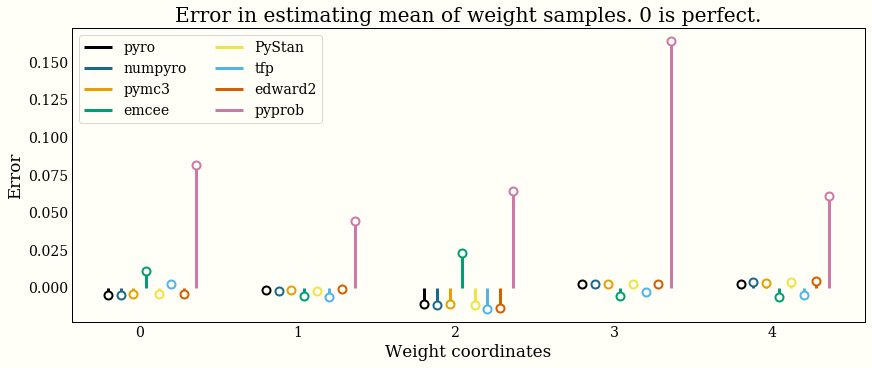

In [22]:
true = np.linalg.inv(X.T.dot(X) + np.eye(5)).dot(X.T.dot(y_obs))

outputs = {
    'pyro': np.array([t.nodes['w']['value'].numpy() for t in py_mcmc.exec_traces]).mean(axis=0),
    'numpyro': npyro_samples['w'].mean(axis=0),
    'pymc3': trace['w'].mean(axis=0),
    'emcee': sampler.chain.mean(axis=0).mean(axis=0),
    'PyStan': list(fit.extract('w').values())[0].mean(axis=0),
    'tfp': tf.reduce_mean(samples, axis=0).numpy(),
    'edward2': tf.reduce_mean(ed_samples, axis=0).numpy(),
    'pyprob': posterior.mean.numpy(),

}

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
bg = ax.get_facecolor()

offset = 0.4

for idx, (name, value) in enumerate(outputs.items()):
    x = np.arange(5) + (idx * offset / 5 - offset / 2)
    y = true - value.flatten()
    ax.vlines(x, 0, y, label=name, color=f'C{idx}')
    ax.plot(x, y, 'o', color=f'C{idx}', mfc=bg)

ax.set_title('Error in estimating mean of weight samples. 0 is perfect.')
ax.set_ylabel('Error')
ax.set_xlabel('Weight coordinates')
ax.legend(ncol=2);